# Multi Armed Bandits Implementations
Will be exploring cases of explore first greedy, epsilon greedy, UCB, and gradient bandit

## Package importation

In [54]:
import numpy as np
import random 
import matplotlib.pyplot as plt

# Algorithm Function defenitions
Functions all take in 2 inputs in the form of they're respective paramter and then the data of the arm.

Epsilon Greedy and UCB have a 3rd input of Explore depth. This will be set as 1 during simulation

All functions give 2 outputs of the final output performance as well as an array of all performance data at all time steps 

## Explore First Greedy Function Definition

In [55]:
def explore_greedy(N, arms_data):
    T, num_arms = arms_data.shape

    curr_greedy = np.zeros(T)
    explore_arr = np.zeros(num_arms * N).reshape(num_arms,N)
    
    for a in range(num_arms):
        for i in range(N):
            explore_arr[a][i] = arms_data[a * N + i][a]
            curr_greedy[a * N + i] = arms_data[a * N + i][a]
    
    arm_sample_mean = np.zeros(num_arms)
    arm_sample_mean =  np.mean(explore_arr, axis= 1)
    best = arm_sample_mean.argmax()
    for i in range(N * num_arms, T):
        curr_greedy[i] = arms_data[i][best]
    
    greedy_perf = np.sum(curr_greedy)

    return greedy_perf, curr_greedy 

## Epsilon Greedy Function Definition

In [56]:
def epsilon_greedy(E, arms_data, explore_amount):
    T, num_arms = arms_data.shape
    curr_greedy = np.zeros(T)
    arm_sample_mean = np.zeros(num_arms * 2).reshape(num_arms,2)

    for arm in range(num_arms):
        for i in range(explore_amount):
            curr_greedy[arm * explore_amount + i] = arms_data[arm * explore_amount + i][arm]
            old_sample_mean = arm_sample_mean[arm][0]
            old_sample_amount = arm_sample_mean[arm][1]
            arm_sample_mean[arm][0] = old_sample_mean * old_sample_amount / (old_sample_amount + 1) + 1 / (old_sample_amount + 1) * arms_data[arm * explore_amount + i][arm]
            arm_sample_mean[arm][1] += 1


    for i in range(num_arms * explore_amount, T):
        prob = random.random()
        if prob >= E:
            arm = arm_sample_mean[:,0].argmax()
        else:
            # Explore
            arm = random.randint(0,9)
        
        curr_greedy[i] = arms_data[i][arm]
        old_sample_mean = arm_sample_mean[arm][0]
        old_sample_amount = arm_sample_mean[arm][1]
        arm_sample_mean[arm][0] = old_sample_mean * old_sample_amount / (old_sample_amount + 1) + 1 / (old_sample_amount + 1) * arms_data[i][arm]
        arm_sample_mean[arm][1] += 1

    E_means_perf = np.sum(curr_greedy)
    return E_means_perf, curr_greedy

## UCB Function Definition

In [57]:
def UCB(exploration, arms_data, explore_amount):
    T, num_arms = arms_data.shape
    curr_UCB = np.zeros(T)
    arm_sample_mean = np.zeros(num_arms * 2).reshape(num_arms,2)
    
    for arm in range(num_arms):
        for i in range(explore_amount):
            curr_UCB[arm * explore_amount + i] = arms_data[arm * explore_amount + i][arm]
            old_sample_mean = arm_sample_mean[arm][0]
            old_sample_amount = arm_sample_mean[arm][1]
            arm_sample_mean[arm][0] = old_sample_mean * old_sample_amount / (old_sample_amount + 1) + 1 / (old_sample_amount + 1) * arms_data[arm * explore_amount + i][arm]
            arm_sample_mean[arm][1] += 1
    
    for i in range(num_arms * explore_amount, T):
        upper_bounds = arm_sample_mean[:,0] + exploration * np.sqrt(np.log(np.sum(i))/ arm_sample_mean[:,1])
        arm = upper_bounds.argmax()
        
        curr_UCB[i] = arms_data[i][arm]
        old_sample_mean = arm_sample_mean[arm][0]
        old_sample_amount = arm_sample_mean[arm][1]
        arm_sample_mean[arm][0] = old_sample_mean * old_sample_amount / (old_sample_amount + 1) + 1 / (old_sample_amount + 1) * arms_data[i][arm]
        arm_sample_mean[arm][1] += 1
    
    
    UCB_perf = np.sum(curr_UCB)
    return UCB_perf, curr_UCB

## Gradient Function Definition

In [58]:
def gradient(alpha, arms_data):
    T, num_arms = arms_data.shape
    curr_gradient = np.zeros(T)
    average_reward = 0
    goodness_arr = np.zeros(num_arms)
    np.zeros(num_arms)
    
    for i in range(T):
        #calculate probabilities
        probability_arr = np.exp(goodness_arr) / np.sum(np.exp(goodness_arr))
        
        #choose arm (softmax)
        arm = np.random.choice(num_arms,p=probability_arr)
        
        #update goodness
        for a in range(num_arms):
            if a == arm:
                goodness_arr[arm] +=  alpha * (arms_data[i][arm] - average_reward) * (1 - probability_arr[arm])
            else:
                goodness_arr[a] -=  alpha * (arms_data[i][arm] - average_reward) * probability_arr[a]
                
        #update means
        curr_gradient[i] = arms_data[i][arm]          
        average_reward = average_reward * i / (i + 1) + 1 / (i + 1) * arms_data[i][arm]
    
    gradient_perf = np.sum(curr_gradient)
    return gradient_perf, curr_gradient

# Simulation

In [59]:
mu, sigma, num_arms = 0, 1, 10
T = 1000
num_sims = 50

N_range = range(1,100)
epsilon_range = np.arange(0,1,0.05)
exploration_range = np.arange(0,3,0.05)
gradient_range = np.arange(0,3,0.05)

ideal_data = []
explore_perf_data = []
epsilon_perf_data = []
UCB_perf_data = []
gradient_perf_data = []

initial_explore_amount = 1

for i in range(num_sims):
    # Setting the arm distributions
    arm_means = np.random.normal(mu, sigma, num_arms)

    # roll T amount of times
    # Format: arms[r][a] where (r =  roll #) and (a = arm #) 
    arms = np.zeros(num_arms * T).reshape(T, num_arms)
    for i in range(T):
        arms[i] = np.random.normal(arm_means,1,num_arms) 

    # Calculate Ideal
    ideal = max(arm_means)*T

    temp = []
    for N in N_range:
        explore_perf, explore_data = explore_greedy(N, arms)
        temp.append(ideal - explore_perf)
    explore_perf_data.append(temp)
    
    temp = []
    for e in epsilon_range:
        epsilon_perf, epsilon_data = epsilon_greedy(e,arms, initial_explore_amount)
        temp.append(ideal - epsilon_perf)
    epsilon_perf_data.append(temp)

    temp = []
    for C in exploration_range:
        UCB_perf, UCB_data = UCB(C, arms, initial_explore_amount)
        temp.append(ideal - UCB_perf)
    UCB_perf_data.append(temp)

    temp = []
    for alpha in exploration_range:
        gradient_perf, gradient_data = gradient(alpha, arms)
        temp.append(ideal - gradient_perf)
    gradient_perf_data.append(temp)

## Paramater vs. Performance Graphing

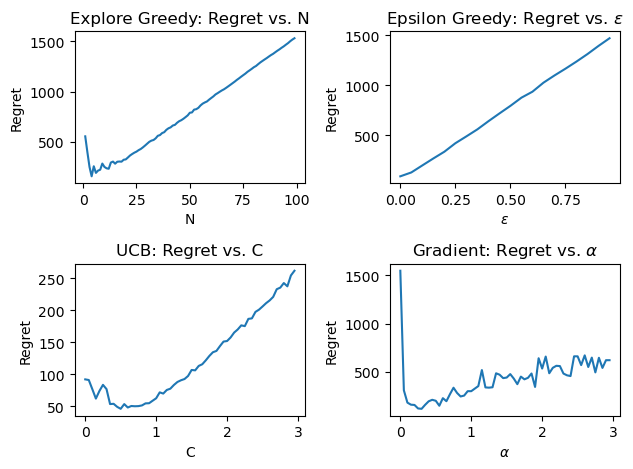

In [60]:
plt.subplot(2,2,1)
explore_mean = np.mean(explore_perf_data,axis=0)
plt.plot(N_range, explore_mean)
plt.title("Explore Greedy: Regret vs. N")
plt.xlabel("N")
plt.ylabel("Regret")

plt.subplot(2,2,2)
epsilon_mean = np.mean(epsilon_perf_data,axis=0)
plt.plot(epsilon_range, epsilon_mean)
plt.title("Epsilon Greedy: Regret vs. $\epsilon$")
plt.xlabel("$\epsilon$")
plt.ylabel("Regret")

plt.subplot(2,2,3)
UCB_mean = np.mean(UCB_perf_data,axis=0)
plt.plot(exploration_range, UCB_mean)
plt.title("UCB: Regret vs. C")
plt.xlabel("C")
plt.ylabel("Regret")

plt.subplot(2,2,4)
gradient_mean = np.mean(gradient_perf_data,axis=0)
plt.plot(gradient_range, gradient_mean)
plt.title("Gradient: Regret vs. $\\alpha$")
plt.xlabel("$\\alpha$")
plt.ylabel("Regret")

plt.tight_layout()
plt.savefig('ParamaterVPerformanceGraphs.jpg')
plt.show()

## UCB vs. Epsilon Graphing

In [78]:
epsilon_data = []
UCB_data = []
num_sims = 100
for _ in range(num_sims):
    arm_means = np.random.normal(mu, sigma, num_arms)
    max_arm = max(arm_means)
    arms = np.zeros(num_arms * T).reshape(T, num_arms)
    for i in range(T):
        arms[i] = np.random.normal(arm_means,1,num_arms)


    epsilon = 0.1
    epsilon_perf, epsilon_out = epsilon_greedy(epsilon, arms, 1)

    curr_epsilon_data = np.zeros(T)
    curr_epsilon_data[0] = max_arm - epsilon_out[0]
    for i in range(1,T):
        curr_epsilon_data[i] = max_arm - epsilon_out[i] + curr_epsilon_data[i-1]
    epsilon_data.append(curr_epsilon_data)

    C = 0.5
    UCB_perf, UCB_out = UCB(C, arms, 1)

    curr_UCB_data = np.zeros(T)
    curr_UCB_data[0] = max_arm - UCB_out[0]
    for i in range(1,T):
        curr_UCB_data[i] = max_arm - UCB_out[i] + curr_UCB_data[i-1]
    UCB_data.append(curr_UCB_data)

epsilon_data = np.mean(epsilon_data, axis = 0)
UCB_data = np.mean(UCB_data, axis = 0)


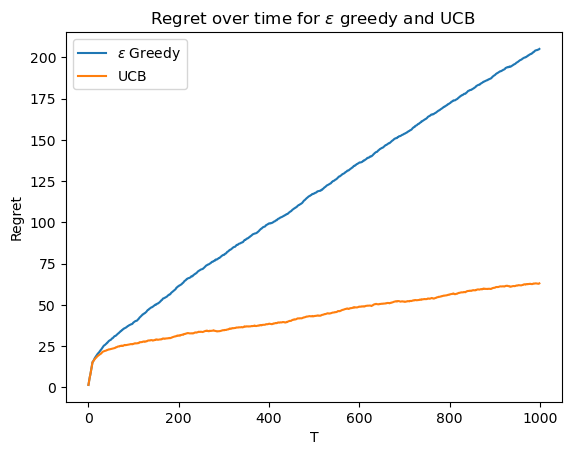

In [84]:

plt.plot(range(T), epsilon_data, label="$\epsilon$ Greedy")
plt.plot(range(T), UCB_data, label="UCB")

plt.title("Regret over time for $\epsilon$ greedy and UCB ")
plt.xlabel("T")
plt.ylabel("Regret")

plt.legend()
plt.savefig('epsilonVsUCB.jpg')
plt.show()